<a href="https://colab.research.google.com/github/kaitouz/ITMO/blob/main/AI-systems/Lab0_Part2_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [1]:
#import os
#os.environ['THEANO_FLAGS'] = "device=cuda,force_device=True,floatX=float32"
#import theano

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import Callback
from keras import regularizers
from keras import optimizers

from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import *

import numpy as np

In [2]:
import tensorflow as tf
seed=42
np.random.seed(seed)
tf.random.set_seed(seed)

# Import data

In [3]:
def one_hot(y):
    t = np.zeros((len(y), np.max(y) + 1))
    t[np.arange(len(y)), y] = 1
    return t

In [4]:
#PUT HERE DATA FROM https://keras.io/datasets/ 

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data() 

# flatten data
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# transform decimal to unitary code
y_train = one_hot(y_train)
y_test = one_hot(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_train[1])

(60000, 784)
(60000, 10)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 163 252 252 252 253 2

## Experimentation

Plot drawing

In [5]:
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Setting parameters

In [6]:
style = {'description_width': 'initial'}
@interact_manual(
    n_layers=IntSlider(min=0, max=4, value=2, description='Layers: '),
    layer_size=IntSlider(min=0, max=20, value=6, description='Neurons per layer: ', style=style),
    layer1_type=Dropdown(options=['softmax', 'relu', 'tanh', 'sigmoid', 'linear'], value='relu',
                          description='Layer 1 activation type: ', style=style),
    layer2_type=Dropdown(options=['softmax', 'relu', 'tanh', 'sigmoid', 'linear'], value='relu',
                          description='Layer 2 activation type ', style=style),
    layer3_type=Dropdown(options=['softmax', 'relu', 'tanh', 'sigmoid', 'linear'], value='relu',
                          description='Layer 3 activation type: ', style=style),
    layer4_type=Dropdown(options=['softmax', 'relu', 'tanh', 'sigmoid', 'linear'], value='relu',
                          description='Layer 4 activation type: ', style=style),
    layer_out_type=Dropdown(options=['softmax', 'relu', 'tanh', 'sigmoid', 'linear'], value='sigmoid',
                          description='Output layer activation type: ', style=style),
    loss_func=Dropdown(options={
        'Standard deviation': 'mse', 
        'Mean absolute deviation': 'mae',
        'Binary crossentropy': 'binary_crossentropy',
        'Categorical crossentropy': 'categorical_crossentropy'
    }, value='categorical_crossentropy', description='Loss function: ', style=style),
    batch_size = BoundedIntText(min=0, max=len(x_train), value=100, description='Batch size: ', style=style),
    lr=ToggleButtons(options=["-0.1", "0", "0.001", "0.01", "0.05", "0.1", "0.5", "1", "5"], 
                               value="0.01", description='Learn rate: ', style=style),
    l1=ToggleButtons(options=["-0.1", "0", "0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05", "0.1"], 
                               value="0.0001", description='Regularization  L1: ', style=style),
    l2=ToggleButtons(options=["-0.1", "0", "0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05", "0.1"], 
                               value="0.0001", description='Regularization  L2: ', style=style),
    epochs=IntSlider(min=10, max=100, step=10, value=20, description='Epoch count: ', style=style),
)
def interactive_learning(n_layers, loss_func, batch_size, lr, l1, l2, 
                         layer_out_type, epochs,
                         layer_size,
                         layer1_type, layer2_type, layer3_type, layer4_type):
    layer_sizes = [layer_size, layer_size, layer_size, layer_size]
    layer_types = [layer1_type, layer2_type, layer3_type, layer4_type]
    lr = float(lr)
    l1 = float(l1)
    l2 = float(l2)
    
    model = Sequential()
    
    if n_layers == 0:
        model.add(Dense(len(y_train[0]), activation=layer_out_type, 
                        input_shape=x_train[0].shape, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    else:
        model.add(Dense(layer_sizes[0], activation=layer_types[0], 
                        input_shape=x_train[0].shape, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
        for i in range(1, n_layers):
            model.add(Dense(layer_sizes[i], activation=layer_types[i],
                           kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
        model.add(Dense(len(y_train[0]), activation=layer_out_type, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    
    model.compile(
     optimizer = optimizers.SGD(learning_rate=lr),
     loss = loss_func,
     metrics = ["accuracy"]
    )
    
    history = model.fit(
     x_train, y_train,
     epochs=epochs,
     batch_size=batch_size,
     validation_data=(x_test, y_test),
     verbose=1
    )
    
    # print('Accuracy: ', history.history['val_accuracy'][-1])
    # plot_accuracy(history)
    return history.history['val_accuracy'][-1], history

interactive(children=(IntSlider(value=2, description='Layers: ', max=4), Dropdown(description='Loss function: …

In [7]:
tab = []
tab_hist = []
tab_model = []
for lr in ["-0.1", "0", "0.001", "0.01", "0.05", "0.1", "0.5", "1", "5"]:
    line = []
    line_hist = []
    for L1 in ["-0.1", "0", "0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05", "0.1"]:
        acc, hist = interactive_learning(n_layers=2, loss_func='categorical_crossentropy', batch_size=100, lr=lr, l1=L1, l2='0.0001', 
                         layer_out_type='sigmoid', epochs=20, layer_size=6,
                         layer1_type='relu', layer2_type='relu', layer3_type='relu', layer4_type='relu')
        line_hist.append(hist)
        line.append(acc)
        print(L1, acc)

    tab_hist.append(line_hist)
    tab.append(line)
    print(tab)

Epoch 1/20
600/600 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.0985 - val_loss: nan - val_accuracy: 0.0980
Epoch 2/20
600/600 [==============================] - 4s 6ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 3/20
600/600 [==============================] - 4s 6ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 5/20
600/600 [==============================] - 3s 6ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 6/20
600/600 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 7/20
600/600 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 8/20
600/600 [============================

In [8]:
import pandas as pd
df = pd.DataFrame(tab, columns=["-0.1", "0", "0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05", "0.1"], index=["-0.1", "0", "0.001", "0.01", "0.05", "0.1", "0.5", "1", "5"])
df

,-0.1,0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1
-0.1,0.0980,0.0980,0.0980,0.0980,0.0980,0.0980,0.0980,0.0980,0.0980
0,0.0781,0.0970,0.1175,0.0668,0.0860,0.0945,0.1576,0.1105,0.0962
0.001,0.1135,0.1136,0.2314,0.3326,0.2015,0.2110,0.4908,0.8392,0.7078
0.01,0.1135,0.1506,0.1135,0.1135,0.1135,0.1135,0.8249,0.1099,0.1135
0.05,0.1135,0.1135,0.1135,0.1135,0.2132,0.1135,0.1135,0.1135,0.1135
0.1,0.1135,0.1135,0.1135,0.1135,0.1135,0.1135,0.1135,0.1135,0.1135
0.5,0.1135,0.1135,0.1135,0.1135,0.1135,0.1135,0.1135,0.1135,0.1135
1,0.1028,0.1028,0.1028,0.1028,0.1028,0.1028,0.1028,0.1028,0.1028
5,0.1028,0.1028,0.1028,0.1028,0.1028,0.1028,0.1028,0.1028,0.1028


In [9]:
print(tab[2][7])

0.8392000198364258


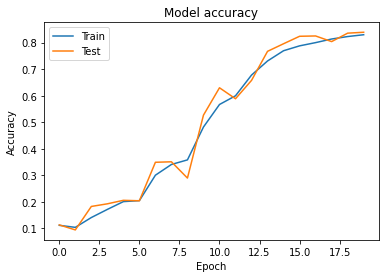

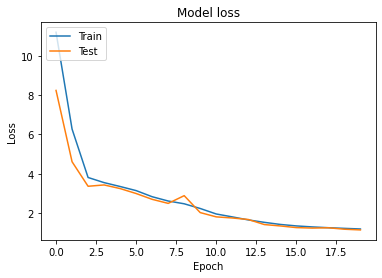

In [10]:
plot_accuracy(tab_hist[2][7])